### Suppport Vector Machine


Support Vector Machine (SVM) is a supervised learning algorithm that can be used for classification or regression problems.<br> The main idea behind SVM is to find the best **boundary** (or hyperplane) that separates the data into different classes. The best boundary is the one that **maximizes the distance** between the closest data points of different classes, also known as the **margin**. The data points that are closest to the boundary are called **support vectors** and they play a key role in determining the position of the boundary.

<img src="Images/SVM.png" width="300"></img>

The process of finding the best boundary can be formulated as an optimization problem, where the objective is to minimize the misclassification error while maximizing the margin.

In the case of non-linearly separable data, SVM can still be used by transforming the data into a higher dimensional space where a linear boundary can be found. This is done by using a kernel function (such as polynomial kernel, RBF kernel, etc.), which maps the data into a higher dimensional space without actually computing the coordinates of the data in that space.

In this notebook I will cover three data cases:
* **Hard**-margin SVM (data is linearly separable, no misclassifications allowed)
* **Soft**-margin SVM (data is linearly separable, misclassifications allowed)
* **Kernel** SVM (data is not linearly separable)

### Hard-Margin SVM

#### Read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from numpy import linalg
import cvxpy as cp
from sklearn.svm import SVC
from scipy.spatial import ConvexHull as ConvexHull
from sklearn.datasets import make_blobs, make_circles

sns.set_style('darkgrid')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.row_columns', None)

In [191]:
X, y = make_blobs(n_samples = 500, centers = 2, cluster_std = 0.8, n_features = 2, random_state=50)
X, y = pd.DataFrame(X+10).rename(columns={0:'feature1', 1: 'feature2'}), pd.Series(y).replace({0: -1, 1: 1}).rename('label')
pd.concat([X, y], axis=1).head()

feature1  feature2  label
0   5.423979  7.052790      1
1   8.614793  4.686008     -1
2   9.502056  3.473197     -1
3  10.003658  4.790038     -1
4   9.183459  4.463745     -1

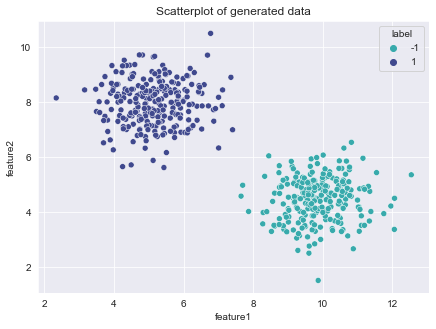

In [192]:
plt.figure(figsize=(7, 5))
plt.title('Scatterplot of generated data')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plt.show()

#### Cost Function (Hard-Margin)

<img src="Images/Hard_margin_graph.png" width="400"></img>

The graph above contains a lot of information, so let's break it down:<br>

* The **Decision Boundary** is the line in the middle and it is defined by $w^Tx - b = 0$, representing the equation of a hyperplane $w_1 x_1 + ... + w_nx_n = 0$<br>
* The <font color='#e0c146'>**positive hyperplane**</font> and the <font color='#3aa9cf'>**negative hyperplane**</font> are the two dotted lines to the side of the Decision Boundary, which delimit the support vectors. <br>
* The **perpendicular vector** to the Decision Boundary is $\vec{w}$, the weight vector.
* The **support vectors** are any points that lie exactly on either of the hyperplanes and therefore follow $w^Tx - b = 1$ or $w^Tx - b = -1$.

The **objective** is to find a Decision Boundary that maximizes the margin, which is the distance between each positive/negative hyperplane and the Decision Boundary.

Let's establish a value for that margin:<br>
Take a vector $\vec{x}$ on the Decision Boundary $\rightarrow w^T\vec{x} - b =0$<br>
Now, we want to know the perpendicular distance from the Decision Boundary to either positive/negative hyperplane in the direction of the weight vector $\vec{w}$ (perpendicular direction).<br>
Therefore, let's solve the following equation for k: 
$$
w^T(\vec{x} + k\frac{w}{||w||}) - b = 1 \rightarrow w^T\vec{x} + k\frac{w^T w}{||w||} - b = 1 \rightarrow k\frac{w^T w}{||w||}1 = 1 \rightarrow k\frac{||w||^2}{||w||} = 1 \rightarrow k = \frac{1}{||w||}
$$

k represents the distance from the Decision Boundary to one of the support hyperplanes, therefore the total margin (M) is: 
$$
M = \frac{2}{||w||}
$$

As mentioned before, we want to maximize the margin:
$$
max \frac{2}{||w||} \rightarrow max \frac{1}{||w||} \rightarrow  min ||w|| \rightarrow  min \frac{1}{2}||w||^2 
$$

BUT, there is one constraint. We need that whatever $w$ and $b$ we choose, all data points on the side of the <font color='#e0c146'>**positive hyperplane**</font> are classified as a positive sample and all data points on the side of the <font color='#3aa9cf'>**negative hyperplane**</font> are classified as a negative sample. Mathematically, that means that

$$
\text{If }y_i = 1 \rightarrow w^T x_i + b \geq 1\\
\text{If }y_i = -1 \rightarrow w^T x_i + b \leq -1
$$

Which can be written in the following compact form by substituting in the $y$:

$$
y_i(w^T x_i + b) \geq 1 \text{ for } y_i = +1, -1\\
$$

Therefore, the cost function for hard-margin SVM along with its constraints is the following:
<img src="Images/SVM_equation(hard).png" width="500"></img>

In [193]:
class SVM_hard:
    
    def costFunction(self, w):
        return 0.5 * cp.norm(w)**2
    
    def fit(self, X, y):
        # Define the parameters
        w, b = cp.Variable(2), cp.Variable()

        # Define the optimization constraint
        self.constraint = [y[i]*(w.T@X.loc[i] + b) >= 1 for i in range(len(X))]

        # Solve the optimization problem
        problem = cp.Problem(cp.Minimize(self.costFunction(w)), self.constraint)
        problem.solve()
        
        # Assign the optimal values of the parameters
        self.w, self.b = w.value, b.value

        # Find the support vectors
        self.support_vectors = []
        for x in X.values:
            value = self.w @ x.T + self.b
           
            if round(value, 5) == 1 or round(value, 5) == -1: #If point is on a support hyperplane (wx + b = 1 or wx + b = -1)
                self.support_vectors.append(x)   

    def predict(self, X):
        # Calculate the perpendicular distance of the point to the margin
        value = self.w @ x.T + self.b

        if value >=0: 
            return 1
        else: 
            return -1

In [194]:
# Create an SVM object and fit it with our data
svm = SVM_hard()
svm.fit(X, y)

#### Decision Boundary visualization

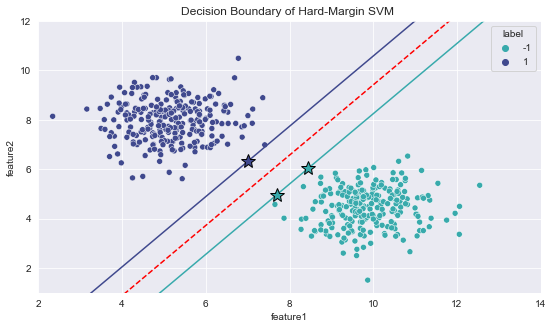

In [196]:
x = np.arange(0, 20) 
DB_y = -(svm.w[0] / svm.w[1]) * x - svm.b / svm.w[1]
pos_margin_y = -(svm.w[0] / svm.w[1]) * x - (svm.b+1) / svm.w[1]
neg_margin_y = -(svm.w[0] / svm.w[1]) * x - (svm.b-1) / svm.w[1]

plt.figure(figsize=(9, 5))
plt.title('Decision Boundary of Hard-Margin SVM ')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plt.plot(x, DB_y, 'r--')
plt.plot(x, pos_margin_y, '#38aaac')
plt.plot(x, neg_margin_y, '#40498e')
plt.plot(svm.support_vectors[0][0], svm.support_vectors[0][1], marker="*", markersize=15, markeredgecolor="black", markerfacecolor="#40498e")
plt.plot(svm.support_vectors[1][0], svm.support_vectors[1][1], marker="*", markersize=15, markeredgecolor="black", markerfacecolor="#38aaac")
plt.plot(svm.support_vectors[2][0], svm.support_vectors[2][1], marker="*", markersize=15, markeredgecolor="black", markerfacecolor="#38aaac")

plt.xlim([2, 14])
plt.ylim([1, 12])
plt.show()

### Soft-Margin SVM

#### Read data

In [202]:
X, y = make_blobs(n_samples = 500, centers = 2, cluster_std = 1.5, n_features = 2, random_state=50)
X, y = pd.DataFrame(X+10).rename(columns={0:'feature1', 1: 'feature2'}), pd.Series(y).replace({0: -1, 1: 1}).rename('label')
pd.concat([X, y], axis=1).head()

feature1  feature2  label
0   5.699167  6.288208      1
1   7.497209  4.794811     -1
2   9.160826  2.520790     -1
3  10.101330  4.989866     -1
4   8.563456  4.378068     -1

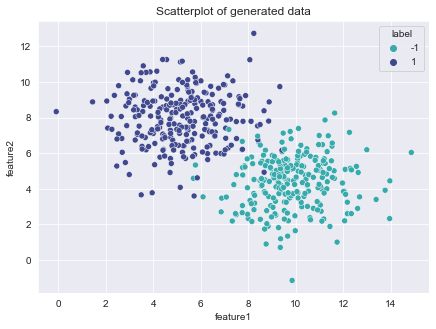

In [203]:
plt.figure(figsize=(7, 5))
plt.title('Scatterplot of generated data')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plt.show()

#### Cost Function (Soft-Margin)

We just use an additional **penalizing factor** in the cost function called $\xi$. This factor is the distance exceeded from the respective support hyperplane by a data point towards the other class.

Therefore, if the data point is well within the support hyperplane, the penalizing factor ùúâ·µ¢ is 0. Else if the data point is on the other side, this factor ùúâ·µ¢ is equal to its distance between the datapoint and the support hyperplane. Hence, the value ùúâ·µ¢ is a non-negative number.

<img src="Images/Soft_margin_graph.png" width="400"></img>

Along witnh the penalizing factor, a **regularization parameter** C is also introduces in order to control the trade-off between maximizing the margin and minimizing the misclassification error. A small value of C will result in a larger margin but potentially more misclassifications, while a large value of C will result in a smaller margin but potentially fewer misclassifications.

The new cost function is defined as:
<img src="Images/SVM_equation(soft).png" width="600"></img>

In [204]:
class SVM_soft:
    
    def costFunction(self, w, C, error):
        return 0.5 * cp.norm(w)**2 + C * cp.sum(error)
    
    def fit(self, X, y, C):
        
        m, n = X.shape
        # Define the parameters
        w, b, error = cp.Variable(n), cp.Variable(), cp.Variable(m)
        
        # Define the optimization constraint
        constraint1 = [y[i]*(w.T@X.loc[i] + b) >= 1 - error[i] for i in range(len(X))]
        constraint2 = [error[i] >= 0 for i in range(len(X))]
        self.constraint = constraint1 + constraint2
        
        # Solve the optimization problem
        problem = cp.Problem(cp.Minimize(self.costFunction(w, C, error)), self.constraint)
        problem.solve()
        
        # Assign the optimal values of the parameters
        self.w, self.b, self.error = w.value, b.value, error.value
        
        # Find the support vectors
        self.support_vectors = []
        for x in X.values:
            value = self.w @ x.T + self.b
           
            #If point is on a support hyperplane (wx + b = 1 or wx + b = -1)
            if round(value, 5) == 1 or round(value, 5) == -1: 
                self.support_vectors.append(x)   

    def predict(self, X):
        # Calculate the perpendicular distance of the point to the margin
        value = self.w @ x.T + self.b

        if value >=0: 
            return 1
        else: 
            return -1

In [205]:
# Create an SVM object and fit it with our data
svm = SVM_soft()
svm.fit(X, y, C=0.1)

#### Decision Boundary visualization

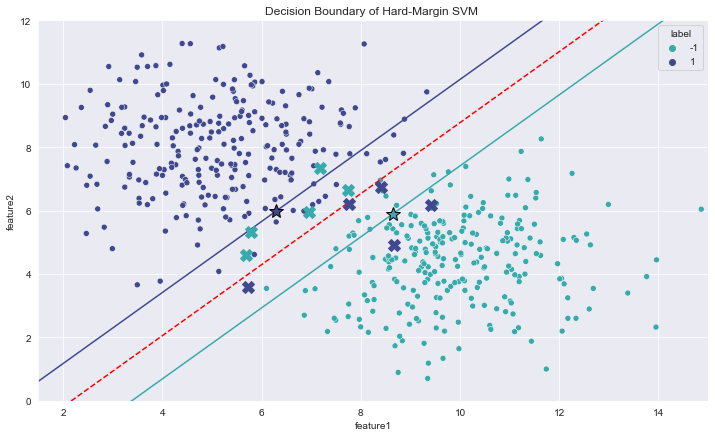

In [208]:
neg_missclassifications = X[svm.error > 1][y[svm.error > 1] == -1]
pos_missclassifications = X[svm.error > 1][y[svm.error > 1] == 1]

x = np.arange(0, 20) 
DB_y = -(svm.w[0] / svm.w[1]) * x - svm.b / svm.w[1]
pos_margin_y = -(svm.w[0] / svm.w[1]) * x - (svm.b+1) / svm.w[1]
neg_margin_y = -(svm.w[0] / svm.w[1]) * x - (svm.b-1) / svm.w[1]

plt.figure(figsize=(12, 7))
plt.title('Decision Boundary of Hard-Margin SVM ')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plt.plot(x, DB_y, 'r--')
plt.plot(x, pos_margin_y, '#38aaac')
plt.plot(x, neg_margin_y, '#40498e')
plt.plot(svm.support_vectors[0][0], svm.support_vectors[0][1], marker="*", markersize=15, markeredgecolor="black", markerfacecolor="#40498e")
plt.plot(svm.support_vectors[1][0], svm.support_vectors[1][1], marker="*", markersize=15, markeredgecolor="black", markerfacecolor="#38aaac")

plt.plot(neg_missclassifications['feature1'], neg_missclassifications['feature2'], color='#38aaac', marker='X', linewidth=0, markersize=12)
plt.plot(pos_missclassifications['feature1'], pos_missclassifications['feature2'], color='#40498e', marker='X', linewidth=0, markersize=12)

plt.xlim([1.5, 15])
plt.ylim([0, 12])
plt.show()

### Kernelized SVM

#### Read data

In [59]:
X, y = make_circles(n_samples=500, noise=0.1, factor=0.3, random_state=50)
X, y = pd.DataFrame(X+10).rename(columns={0:'feature1', 1: 'feature2'}), pd.Series(y).replace({0: -1, 1: 1}).rename('label')
pd.concat([X, y], axis=1).head()

feature1   feature2  label
0   9.737432  10.256906      1
1   9.749626  10.067840      1
2  10.003964   9.654799      1
3   9.834726  10.113857      1
4   9.843939  10.187890      1

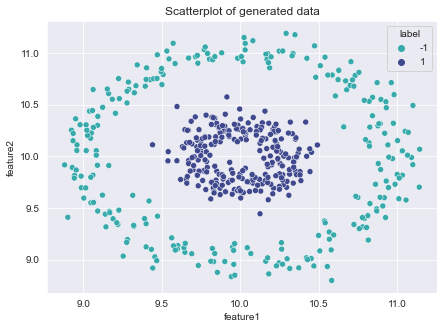

In [60]:
plt.figure(figsize=(7, 5))
plt.title('Scatterplot of generated data')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plt.show()

#### Decision Boundary Visualization

Kernels are used to separate data that is not linearly separable. This is achieved through the utilization of the **kernel trick**, which involves the transformation of the data into a higher-dimensional space where the identification of a hyperplane that is able to better separate the two classes will be more likely. Take a look at the example below:

<img src="Images/kernel_trick.png" width="500"></img>

There are many different kernel functions that can be used, but the most common ones are: 
* Polynomial kernel
* RBF kernel
* Sigmoid kernel.

In [104]:
def plot_svc_decision_function(model):

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [105]:
clf = SVC(kernel='rbf', C=100).fit(X, y)

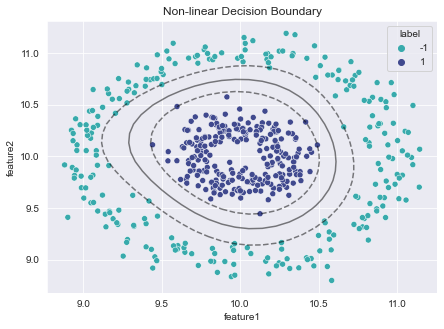

In [107]:
plt.figure(figsize=(7, 5))
plt.title('Non-linear Decision Boundary')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette={1: '#40498e', -1: '#38aaac'})
plot_svc_decision_function(clf)
plt.show()